# MohammadMahdi SharifBeigy

# DEAP Dataset: Advanced Emotion Recognition Mini Project

This notebook implements a comprehensive emotion recognition system using EEG and physiological signals from the DEAP dataset.

## Project Overview
- **Dataset**: DEAP (Database for Emotion Analysis using Physiological Signals)
- **Task**: Multi-class emotion classification using valence, arousal, dominance, and liking
- **Signals**: 32 EEG channels + 8 peripheral physiological signals
- **Subjects**: 32 participants
- **Trials**: 40 music video trials per participant

## 1. Setup and Installation

In [1]:
# Install required packages
#!pip install scikit-learn numpy pandas matplotlib seaborn scipy mne imbalanced-learn xgboost lightgbm -q

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Import Libraries

In [3]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.stats import skew, kurtosis
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Classifiers
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("All libraries imported successfully!")

All libraries imported successfully!


## 3. Configuration and Constants

In [4]:
# Dataset path
DATA_PATH = '/content/drive/My Drive/DeapDb/data_preprocessed_python'

# Dataset constants
NUM_SUBJECTS = 32
NUM_TRIALS = 40
NUM_CHANNELS = 40
SAMPLING_RATE = 128  # Hz
TRIAL_LENGTH = 63  # seconds (8064 samples / 128 Hz)

# Channel information
EEG_CHANNELS = list(range(32))  # First 32 channels are EEG
PERIPHERAL_CHANNELS = list(range(32, 40))  # Last 8 channels are peripheral

CHANNEL_NAMES = [
    # EEG channels (32)
    'Fp1', 'AF3', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'P3', 'P7',
    'PO3', 'O1', 'Oz', 'Pz', 'Fp2', 'AF4', 'Fz', 'F4', 'F8', 'FC6', 'FC2', 'Cz',
    'C4', 'T8', 'CP6', 'CP2', 'P4', 'P8', 'PO4', 'O2',
    # Peripheral channels (8)
    'hEOG', 'vEOG', 'zEMG', 'tEMG', 'GSR', 'Respiration', 'Plethysmograph', 'Temperature'
]

# Emotion labels
EMOTION_LABELS = ['valence', 'arousal', 'dominance', 'liking']

# Frequency bands (Hz)
FREQUENCY_BANDS = {
    'delta': (1, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta': (13, 30),
    'gamma': (30, 50)
}

print(f"Configuration loaded:")
print(f"  - Subjects: {NUM_SUBJECTS}")
print(f"  - Trials per subject: {NUM_TRIALS}")
print(f"  - Channels: {NUM_CHANNELS} ({len(EEG_CHANNELS)} EEG + {len(PERIPHERAL_CHANNELS)} peripheral)")
print(f"  - Sampling rate: {SAMPLING_RATE} Hz")
print(f"  - Emotion dimensions: {EMOTION_LABELS}")

Configuration loaded:
  - Subjects: 32
  - Trials per subject: 40
  - Channels: 40 (32 EEG + 8 peripheral)
  - Sampling rate: 128 Hz
  - Emotion dimensions: ['valence', 'arousal', 'dominance', 'liking']


## 4. Data Loading Functions

In [5]:
def load_subject_data(subject_id, data_path=DATA_PATH):
    """
    Load data for a single subject.

    Parameters:
    -----------
    subject_id : int
        Subject ID (1-32)
    data_path : str
        Path to the data directory

    Returns:
    --------
    data : numpy array
        Shape (40, 40, 8064) - trials x channels x samples
    labels : numpy array
        Shape (40, 4) - trials x emotion labels (valence, arousal, dominance, liking)
    """
    filename = f"{data_path}/s{subject_id:02d}.dat"
    try:
        with open(filename, 'rb') as f:
            subject = pickle.load(f, encoding='latin1')
        return subject['data'], subject['labels']
    except Exception as e:
        print(f"Error loading subject {subject_id}: {e}")
        return None, None


def load_all_subjects(data_path=DATA_PATH, num_subjects=NUM_SUBJECTS):
    """
    Load data for all subjects with tqdm progress bar.

    Parameters:
    -----------
    data_path : str
        Path to the data directory
    num_subjects : int
        Number of subjects to load

    Returns:
    --------
    all_data : list
        List of data arrays for each subject
    all_labels : list
        List of label arrays for each subject
    """
    all_data = []
    all_labels = []

    print("Loading DEAP dataset...")

    # Use tqdm for progress bar
    for subject_id in tqdm(range(1, num_subjects + 1),
                           desc="Loading subjects",
                           unit="subject",
                           colour="green",
                           ncols=100):
        data, labels = load_subject_data(subject_id, data_path)
        if data is not None and labels is not None:
            all_data.append(data)
            all_labels.append(labels)

    print(f"✓ Successfully loaded {len(all_data)} subjects")
    return all_data, all_labels


def create_emotion_classes(labels, threshold=5.0):
    """
    Convert continuous emotion ratings to binary classes.

    Parameters:
    -----------
    labels : numpy array
        Continuous emotion ratings (1-9 scale)
    threshold : float
        Threshold for binary classification (default: 5.0)

    Returns:
    --------
    binary_labels : numpy array
        Binary labels (0: low, 1: high)
    """
    return (labels >= threshold).astype(int)


# Test loading
print("Testing data loading...")
test_data, test_labels = load_subject_data(1)
if test_data is not None:
    print(f"\nData shape: {test_data.shape}")
    print(f"Labels shape: {test_labels.shape}")
    print(f"\nLabel statistics (subject 1):")
    for i, emotion in enumerate(EMOTION_LABELS):
        print(f"  {emotion.capitalize()}: mean={test_labels[:, i].mean():.2f}, std={test_labels[:, i].std():.2f}")

Testing data loading...

Data shape: (40, 40, 8064)
Labels shape: (40, 4)

Label statistics (subject 1):
  Valence: mean=5.12, std=2.49
  Arousal: mean=5.66, std=2.15
  Dominance: mean=5.90, std=2.06
  Liking: mean=6.85, std=1.17


## 5. Feature Extraction Functions

In [6]:
def extract_band_powers(eeg_data, fs=128):
    """
    Extract power spectral density features for different frequency bands.

    Parameters:
    -----------
    eeg_data : ndarray, shape (n_samples, n_channels, n_timepoints)
        EEG data (only EEG channels, not peripheral)
    fs : int
        Sampling frequency (default: 128 Hz)

    Returns:
    --------
    features : ndarray, shape (n_samples, n_channels * n_bands)
        Power spectral features for each channel and frequency band
    feature_names : list
        Names of the features
    """
    from scipy import signal
    from scipy.integrate import simpson

    # Define frequency bands
    bands = {
        'Delta': (1, 4),
        'Theta': (4, 8),
        'Alpha': (8, 13),
        'Beta': (13, 30),
        'Gamma': (30, 45)
    }

    n_samples, n_channels, n_timepoints = eeg_data.shape
    n_bands = len(bands)

    # Initialize feature array
    features = np.zeros((n_samples, n_channels * n_bands))
    feature_names = []

    # Channel names (based on DEAP documentation)
    channel_names = ['Fp1', 'AF3', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'T7',
                     'CP5', 'CP1', 'P3', 'P7', 'PO3', 'O1', 'Oz', 'Pz',
                     'Fp2', 'AF4', 'Fz', 'F4', 'F8', 'FC6', 'FC2', 'Cz',
                     'C4', 'T8', 'CP6', 'CP2', 'P4', 'P8', 'PO4', 'O2']

    print("\n" + "="*80)
    print("EXTRACTING BAND POWER FEATURES")
    print("="*80)
    print(f"Samples: {n_samples}")
    print(f"Channels: {n_channels}")
    print(f"Frequency bands: {list(bands.keys())}")
    print("="*80)

    # Use tqdm for progress
    for sample_idx in tqdm(range(n_samples),
                          desc="Extracting features",
                          unit="sample",
                          colour="cyan",
                          ncols=100):

        for ch_idx in range(n_channels):
            # Get signal for this channel
            sig = eeg_data[sample_idx, ch_idx, :]

            # Compute power spectral density using Welch's method
            freqs, psd = signal.welch(sig, fs=fs, nperseg=256)

            # Extract power for each frequency band
            for band_idx, (band_name, (low_freq, high_freq)) in enumerate(bands.items()):
                # Find frequencies in this band
                freq_mask = (freqs >= low_freq) & (freqs <= high_freq)

                # Compute band power using Simpson's rule for integration
                band_power = simpson(psd[freq_mask], freqs[freq_mask])

                # Store feature
                feature_idx = ch_idx * n_bands + band_idx
                features[sample_idx, feature_idx] = band_power

                # Create feature name (only once)
                if sample_idx == 0:
                    feature_names.append(f"{channel_names[ch_idx]}_{band_name}")

    print(f"\n✓ Feature extraction complete!")
    print(f"  Total features: {features.shape[1]}")
    print(f"  Features per channel: {n_bands}")

    return features, feature_names


print("✓ Band power feature extraction function defined!")

✓ Band power feature extraction function defined!


## 6. Load and Preprocess Dataset

Loading DEAP dataset...


Loading subjects: 100%|████████████████████████████████████████| 32/32 [00:32<00:00,  1.02s/subject]


✓ Successfully loaded 32 subjects

Dataset summary:
  - Total subjects: 32
  - Total trials: 1280
  - Emotion dimensions: 4


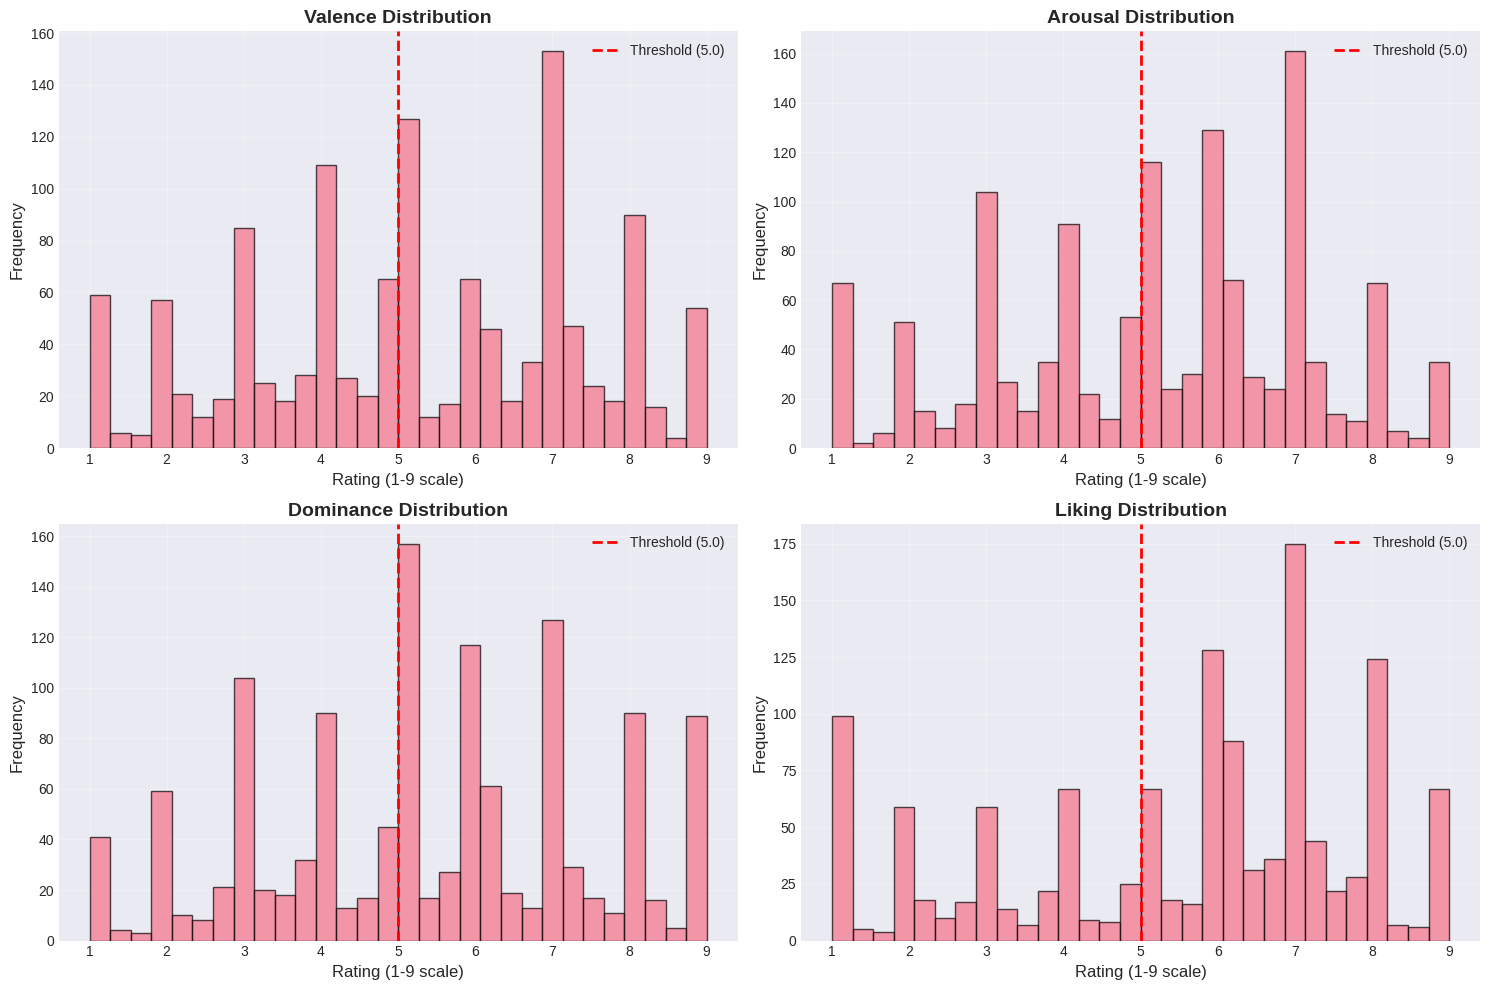


Label statistics:
  Valence:
    Mean: 5.254
    Std:  2.130
    Min:  1.000
    Max:  9.000
  Arousal:
    Mean: 5.157
    Std:  2.020
    Min:  1.000
    Max:  9.000
  Dominance:
    Mean: 5.383
    Std:  2.096
    Min:  1.000
    Max:  9.000
  Liking:
    Mean: 5.518
    Std:  2.282
    Min:  1.000
    Max:  9.000


In [7]:
# Load all subjects
all_data, all_labels = load_all_subjects()

# Concatenate labels from all subjects
y_continuous = np.vstack(all_labels)

print(f"\nDataset summary:")
print(f"  - Total subjects: {len(all_data)}")
print(f"  - Total trials: {y_continuous.shape[0]}")
print(f"  - Emotion dimensions: {y_continuous.shape[1]}")

# Display label distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, emotion in enumerate(EMOTION_LABELS):
    axes[i].hist(y_continuous[:, i], bins=30, edgecolor='black', alpha=0.7)
    axes[i].axvline(5, color='r', linestyle='--', linewidth=2, label='Threshold (5.0)')
    axes[i].set_xlabel('Rating (1-9 scale)', fontsize=12)
    axes[i].set_ylabel('Frequency', fontsize=12)
    axes[i].set_title(f'{emotion.capitalize()} Distribution', fontsize=14, fontweight='bold')
    axes[i].legend()
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('/content/drive/My Drive/DeapDb/Classification/emotion_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nLabel statistics:")
for i, emotion in enumerate(EMOTION_LABELS):
    print(f"  {emotion.capitalize()}:")
    print(f"    Mean: {y_continuous[:, i].mean():.3f}")
    print(f"    Std:  {y_continuous[:, i].std():.3f}")
    print(f"    Min:  {y_continuous[:, i].min():.3f}")
    print(f"    Max:  {y_continuous[:, i].max():.3f}")

## 7. Feature Extraction and Preparation

In [8]:
# Prepare data: Stack all subjects into single array
print("Preparing data for feature extraction...")
all_data_stacked = []

for subject_data in all_data:
    for trial_idx in range(subject_data.shape[0]):
        # Extract only EEG channels (first 32 channels)
        trial_eeg = subject_data[trial_idx, :32, :]
        all_data_stacked.append(trial_eeg)

# Convert to numpy array: (n_samples, n_channels, n_timepoints)
all_data_stacked = np.array(all_data_stacked)

print(f"Data shape: {all_data_stacked.shape}")
print(f"  - Total samples: {all_data_stacked.shape[0]}")
print(f"  - EEG channels: {all_data_stacked.shape[1]}")
print(f"  - Timepoints: {all_data_stacked.shape[2]}")

# Extract band power features
X, feature_names = extract_band_powers(all_data_stacked, fs=SAMPLING_RATE)

print(f"\n✓ Feature matrix shape: {X.shape}")
print(f"  - Number of samples: {X.shape[0]}")
print(f"  - Number of features: {X.shape[1]}")
print(f"\nExample feature names (first 10):")
for i, name in enumerate(feature_names[:10]):
    print(f"  {i+1}. {name}")

# Create binary labels for each emotion dimension
y_binary = {}
for i, emotion in enumerate(EMOTION_LABELS):
    y_binary[emotion] = create_emotion_classes(y_continuous[:, i], threshold=5.0)

# Display class distributions
print("\n" + "="*80)
print("BINARY CLASS DISTRIBUTIONS")
print("="*80)
for emotion in EMOTION_LABELS:
    class_counts = np.bincount(y_binary[emotion])
    print(f"{emotion.capitalize()}:")
    print(f"  Low (0):  {class_counts[0]:4d} ({class_counts[0]/len(y_binary[emotion])*100:.1f}%)")
    print(f"  High (1): {class_counts[1]:4d} ({class_counts[1]/len(y_binary[emotion])*100:.1f}%)")

Preparing data for feature extraction...
Data shape: (1280, 32, 8064)
  - Total samples: 1280
  - EEG channels: 32
  - Timepoints: 8064

EXTRACTING BAND POWER FEATURES
Samples: 1280
Channels: 32
Frequency bands: ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']


Extracting features: 100%|██████████████████████████████████| 1280/1280 [03:13<00:00,  6.62sample/s]


✓ Feature extraction complete!
  Total features: 160
  Features per channel: 5

✓ Feature matrix shape: (1280, 160)
  - Number of samples: 1280
  - Number of features: 160

Example feature names (first 10):
  1. Fp1_Delta
  2. Fp1_Theta
  3. Fp1_Alpha
  4. Fp1_Beta
  5. Fp1_Gamma
  6. AF3_Delta
  7. AF3_Theta
  8. AF3_Alpha
  9. AF3_Beta
  10. AF3_Gamma

BINARY CLASS DISTRIBUTIONS
Valence:
  Low (0):   556 (43.4%)
  High (1):  724 (56.6%)
Arousal:
  Low (0):   526 (41.1%)
  High (1):  754 (58.9%)
Dominance:
  Low (0):   485 (37.9%)
  High (1):  795 (62.1%)
Liking:
  Low (0):   423 (33.0%)
  High (1):  857 (67.0%)


## 8. Exploratory Data Analysis

Analyzing feature correlations...


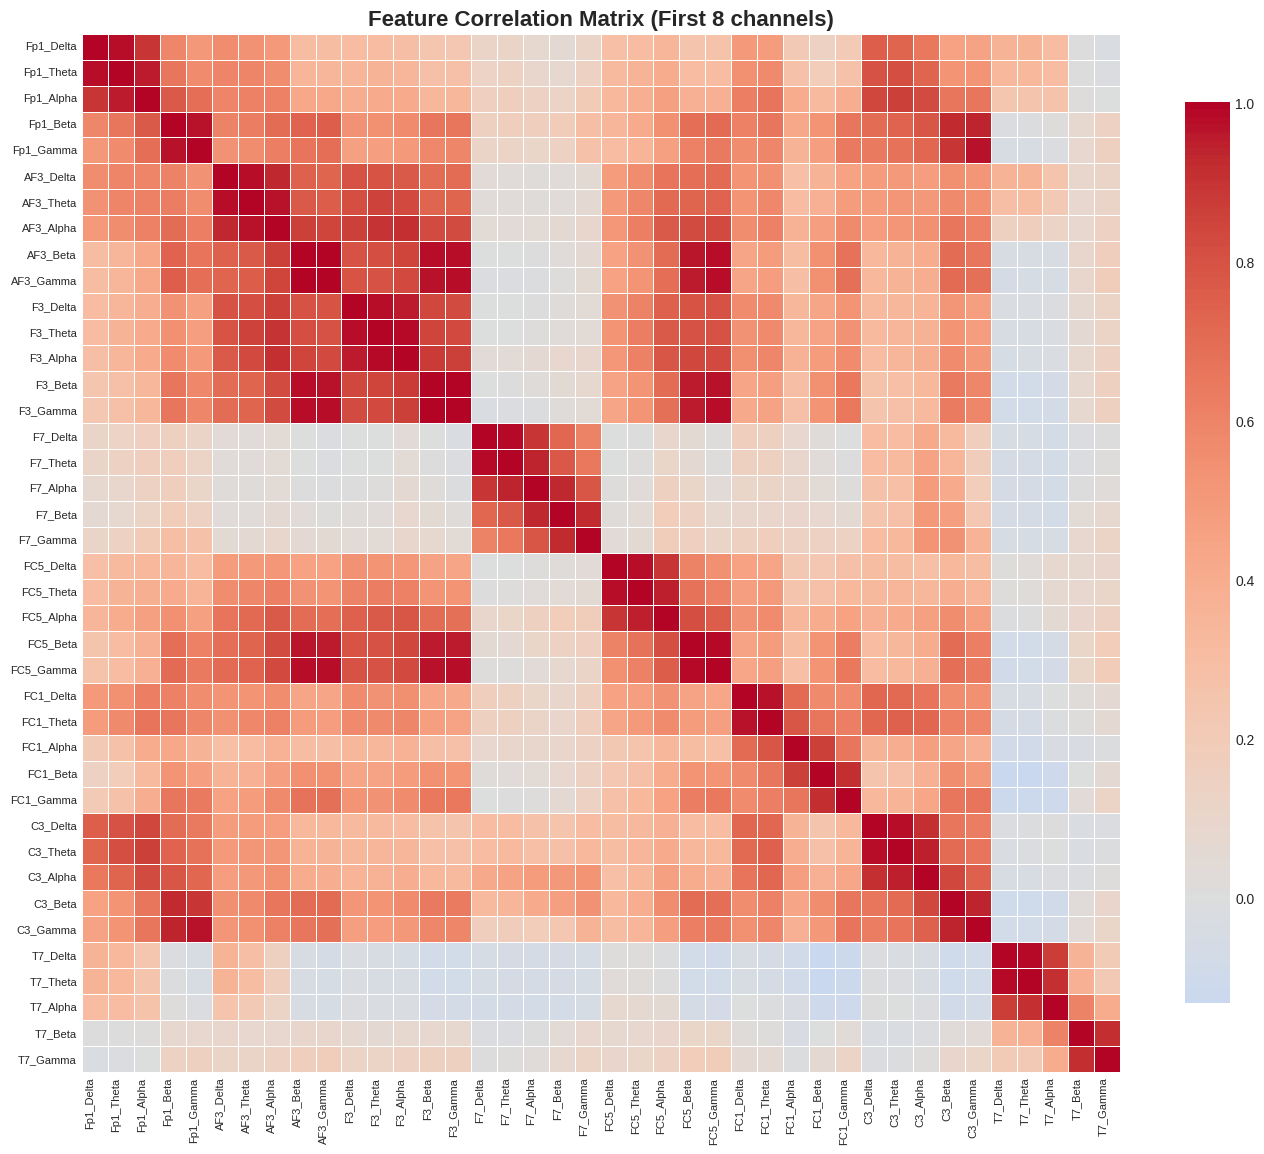


Performing PCA for visualization...


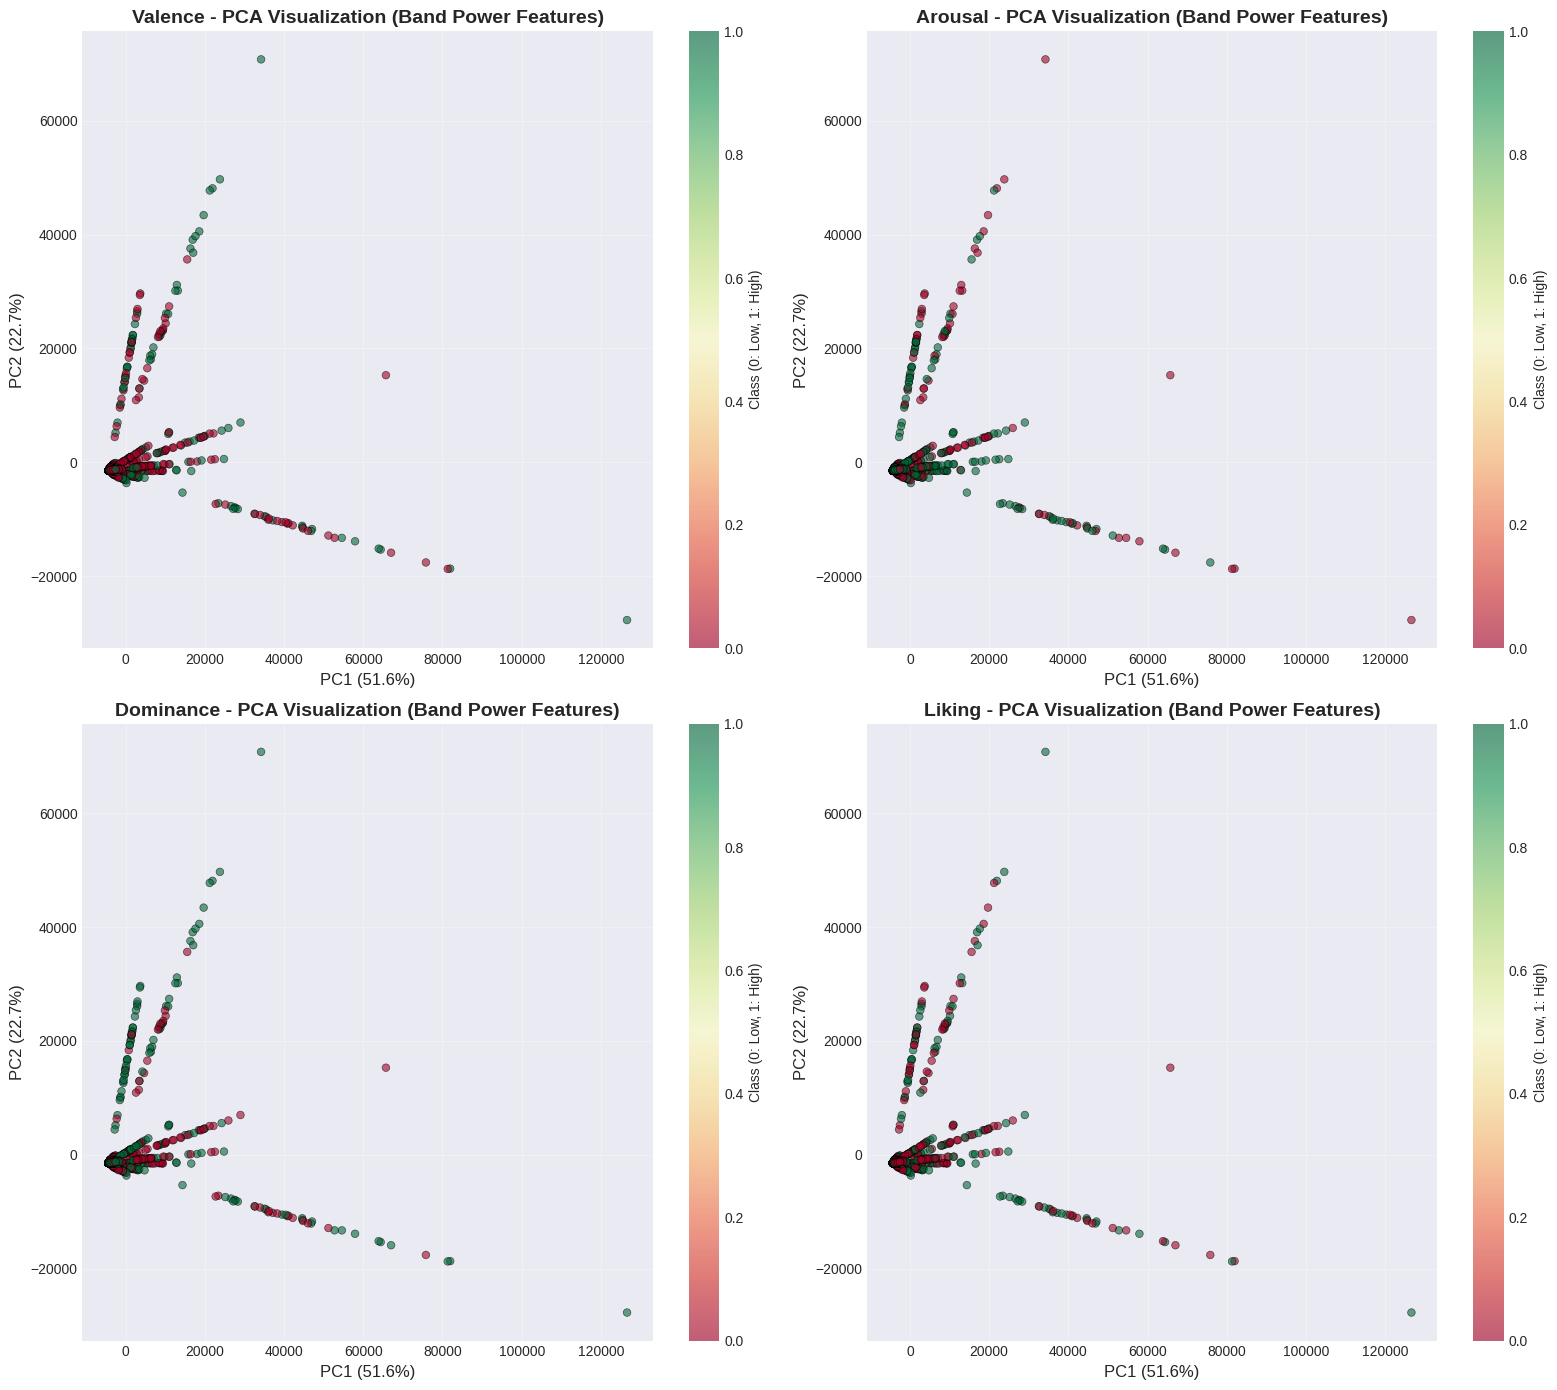


PCA explained variance ratio: [0.51564112 0.22667567]
Total variance explained by 2 components: 74.23%


In [9]:
# Feature correlation heatmap (sample of features)
print("Analyzing feature correlations...")

# Select a subset of features for visualization (e.g., all features for first 3 channels)
n_features_per_channel = 5  # 5 bands
n_channels_to_show = 8  # Show first 8 channels
sample_features = X[:, :n_channels_to_show * n_features_per_channel]
sample_feature_names = feature_names[:n_channels_to_show * n_features_per_channel]

feature_corr = np.corrcoef(sample_features.T)

plt.figure(figsize=(14, 12))
sns.heatmap(feature_corr,
            cmap='coolwarm',
            center=0,
            square=True,
            xticklabels=sample_feature_names,
            yticklabels=sample_feature_names,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8})
plt.title(f'Feature Correlation Matrix (First {n_channels_to_show} channels)',
          fontsize=16, fontweight='bold')
plt.xticks(rotation=90, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.savefig('/content/drive/My Drive/DeapDb/Classification/feature_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

# PCA visualization
print("\nPerforming PCA for visualization...")
pca_viz = PCA(n_components=2)
X_pca = pca_viz.fit_transform(X)

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.ravel()

for i, emotion in enumerate(EMOTION_LABELS):
    scatter = axes[i].scatter(X_pca[:, 0], X_pca[:, 1],
                             c=y_binary[emotion], cmap='RdYlGn',
                             alpha=0.6, s=30, edgecolors='black', linewidth=0.5)
    axes[i].set_xlabel(f'PC1 ({pca_viz.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
    axes[i].set_ylabel(f'PC2 ({pca_viz.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
    axes[i].set_title(f'{emotion.capitalize()} - PCA Visualization (Band Power Features)',
                     fontsize=14, fontweight='bold')
    axes[i].grid(alpha=0.3)
    cbar = plt.colorbar(scatter, ax=axes[i])
    cbar.set_label('Class (0: Low, 1: High)', fontsize=10)

plt.tight_layout()
plt.savefig('/content/drive/My Drive/DeapDb/Classification/pca_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nPCA explained variance ratio: {pca_viz.explained_variance_ratio_}")
print(f"Total variance explained by 2 components: {pca_viz.explained_variance_ratio_.sum()*100:.2f}%")


## 9. Model Training and Evaluation

In [10]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name="Model"):
    """
    Train and evaluate a classification model.
    """
    # Train
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')

    results = {
        'model': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

    return results


def train_and_compare_models(X, y, emotion_name, test_size=0.2, random_state=42):
    """
    Train multiple models and compare their performance.
    """
    print(f"\n{'='*80}")
    print(f"Training models for {emotion_name.upper()}")
    print(f"{'='*80}")

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=0.95, random_state=random_state)  # Keep 95% variance
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    print(f"\nFeatures after PCA: {X_train_pca.shape[1]} (from {X_train_scaled.shape[1]})")
    print(f"Explained variance: {pca.explained_variance_ratio_.sum()*100:.2f}%")

    # Define models
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=random_state),
        'SVM (RBF)': SVC(kernel='rbf', probability=True, random_state=random_state),
        'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=random_state),
        'XGBoost': XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1,
                                 random_state=random_state, eval_metric='logloss'),
        'LightGBM': LGBMClassifier(n_estimators=100, max_depth=6, learning_rate=0.1,
                                   random_state=random_state, verbose=-1)
    }
    #'MLP': MLPClassifier(hidden_layers=(128, 64), max_iter=500, random_state=random_state),
    #'KNN': KNeighborsClassifier(n_neighbors=5)

    # Train and evaluate each model
    results_list = []

    for model_name, model in models.items():
        print(f"\nTraining {model_name}...")
        results = evaluate_model(model, X_train_pca, X_test_pca, y_train, y_test, model_name)
        results_list.append(results)

        print(f"  Accuracy:  {results['accuracy']:.4f}")
        print(f"  Precision: {results['precision']:.4f}")
        print(f"  Recall:    {results['recall']:.4f}")
        print(f"  F1-Score:  {results['f1']:.4f}")

    # Create results dataframe
    results_df = pd.DataFrame([{
        'Model': r['model'],
        'Accuracy': r['accuracy'],
        'Precision': r['precision'],
        'Recall': r['recall'],
        'F1-Score': r['f1']
    } for r in results_list])

    return results_df, results_list, (X_test_pca, y_test), (scaler, pca)


print("Model training functions defined successfully!")

Model training functions defined successfully!


## 10. Train Models for All Emotions

In [11]:
# Dictionary to store all results
all_results = {}

# Train models for each emotion
for emotion in EMOTION_LABELS:
    results_df, results_list, test_data, preprocessors = train_and_compare_models(
        X, y_binary[emotion], emotion
    )

    all_results[emotion] = {
        'results_df': results_df,
        'results_list': results_list,
        'test_data': test_data,
        'preprocessors': preprocessors
    }

print("\n" + "="*80)
print("ALL MODELS TRAINED SUCCESSFULLY!")
print("="*80)


Training models for VALENCE

Features after PCA: 13 (from 160)
Explained variance: 95.64%

Training Logistic Regression...
  Accuracy:  0.5625
  Precision: 0.5714
  Recall:    0.9103
  F1-Score:  0.7021

Training SVM (RBF)...
  Accuracy:  0.5586
  Precision: 0.5672
  Recall:    0.9310
  F1-Score:  0.7050

Training Random Forest...
  Accuracy:  0.5703
  Precision: 0.6000
  Recall:    0.7241
  F1-Score:  0.6562

Training XGBoost...
  Accuracy:  0.5781
  Precision: 0.6108
  Recall:    0.7034
  F1-Score:  0.6538

Training LightGBM...
  Accuracy:  0.5859
  Precision: 0.6182
  Recall:    0.7034
  F1-Score:  0.6581

Training models for AROUSAL

Features after PCA: 13 (from 160)
Explained variance: 95.09%

Training Logistic Regression...
  Accuracy:  0.5938
  Precision: 0.6026
  Recall:    0.9139
  F1-Score:  0.7263

Training SVM (RBF)...
  Accuracy:  0.5703
  Precision: 0.5880
  Recall:    0.9073
  F1-Score:  0.7135

Training Random Forest...
  Accuracy:  0.6211
  Precision: 0.6517
  Recall:

## 11. Comprehensive Results Visualization

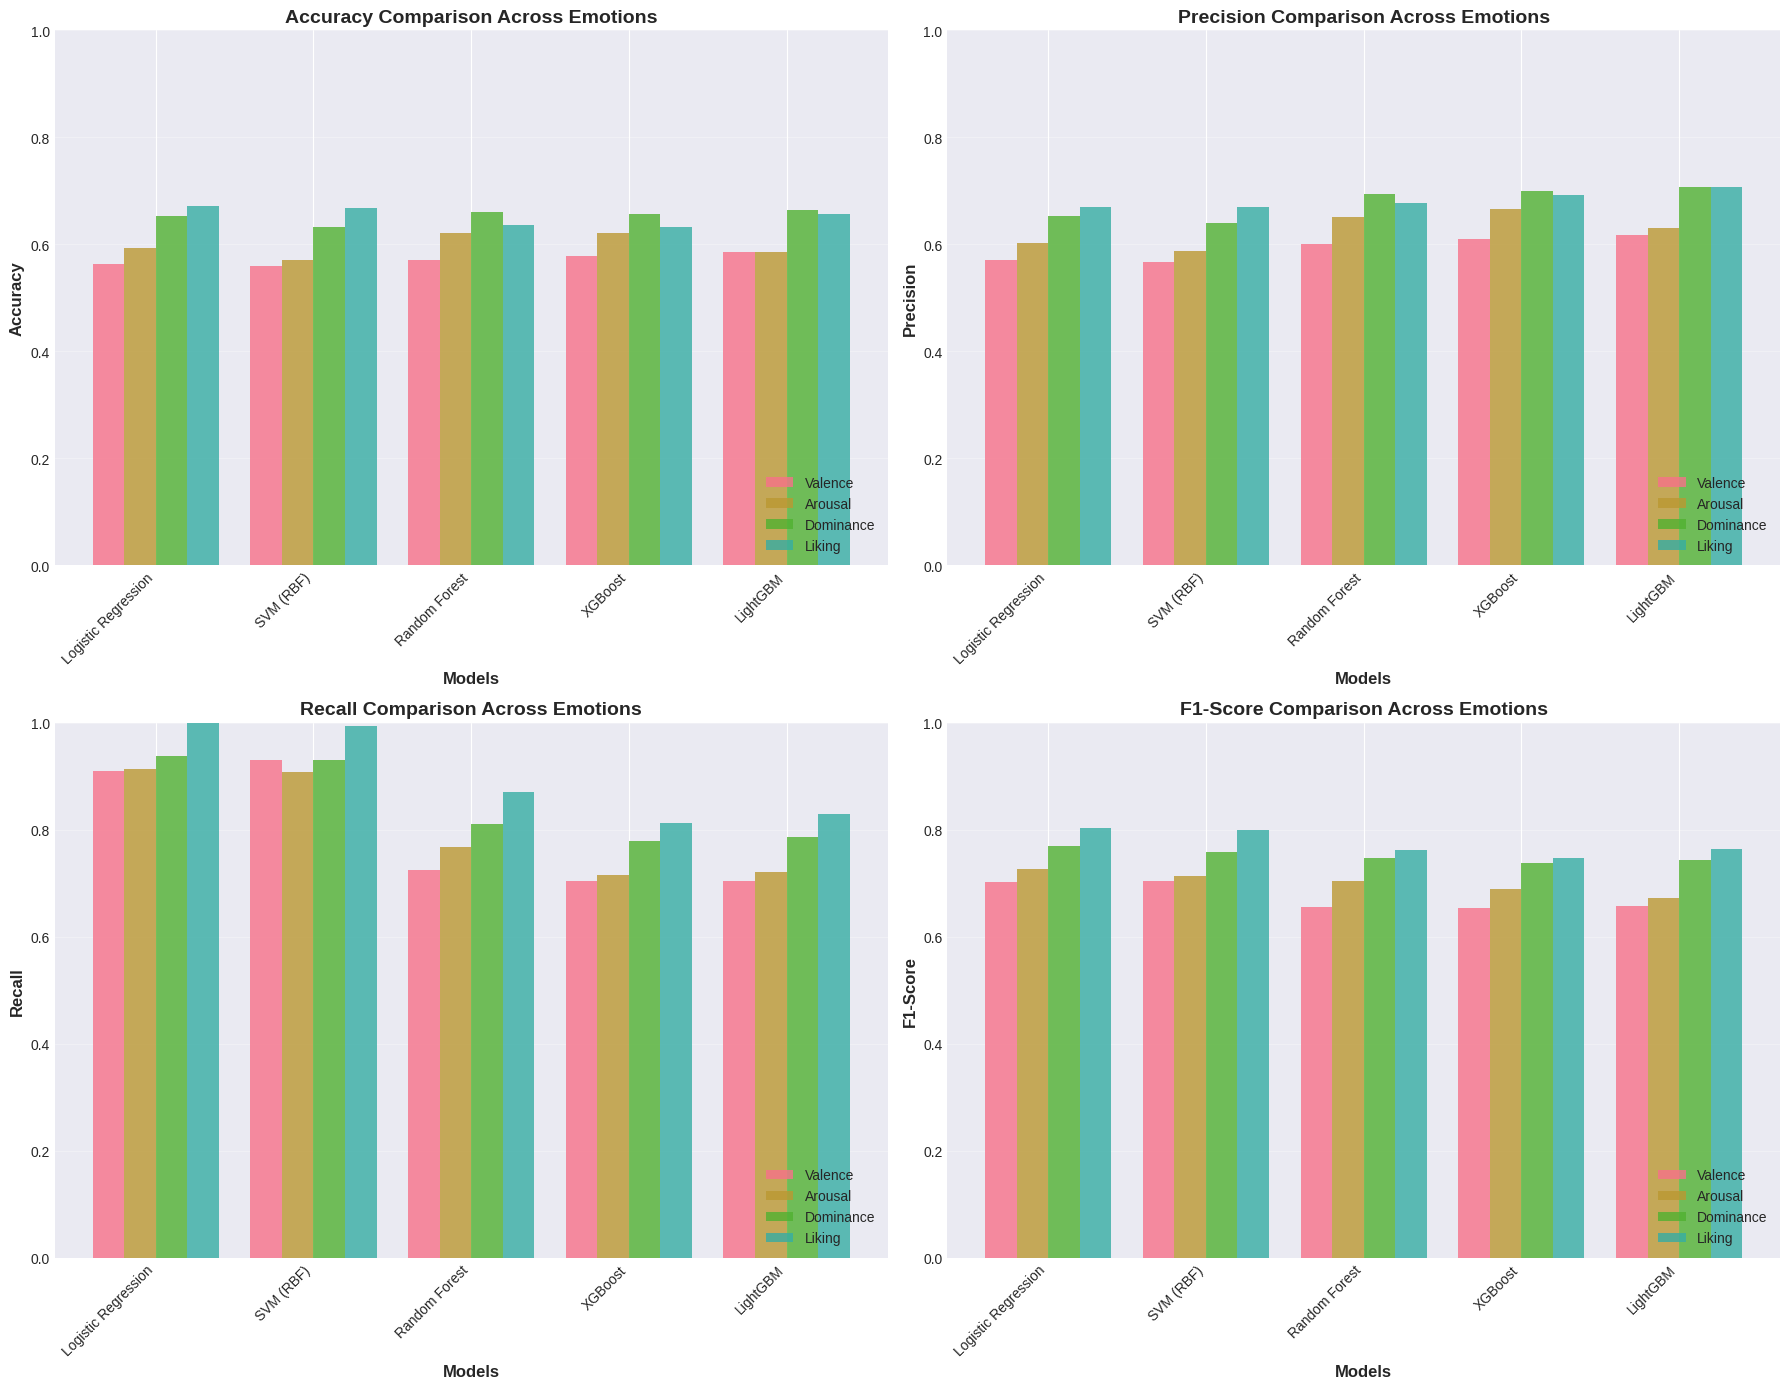

In [12]:
# Compare all models across all emotions
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = axes.ravel()

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for idx, metric in enumerate(metrics):
    data_for_plot = []
    labels_for_plot = []

    for emotion in EMOTION_LABELS:
        results_df = all_results[emotion]['results_df']
        data_for_plot.append(results_df[metric].values)
        labels_for_plot.append(emotion.capitalize())

    # Create grouped bar chart
    x = np.arange(len(results_df))
    width = 0.2

    for i, (data, label) in enumerate(zip(data_for_plot, labels_for_plot)):
        axes[idx].bar(x + i*width, data, width, label=label, alpha=0.8)

    axes[idx].set_xlabel('Models', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel(metric, fontsize=12, fontweight='bold')
    axes[idx].set_title(f'{metric} Comparison Across Emotions', fontsize=14, fontweight='bold')
    axes[idx].set_xticks(x + width * 1.5)
    axes[idx].set_xticklabels(results_df['Model'], rotation=45, ha='right')
    axes[idx].legend(loc='lower right')
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].set_ylim([0, 1])

plt.tight_layout()
plt.savefig('/content/drive/My Drive/DeapDb/Classification/model_comparison_all_emotions.png', dpi=300, bbox_inches='tight')
plt.show()

## 12. Detailed Performance Tables

In [13]:
# Create comprehensive results table
print("\n" + "="*100)
print("COMPREHENSIVE MODEL PERFORMANCE SUMMARY")
print("="*100)

for emotion in EMOTION_LABELS:
    print(f"\n{emotion.upper()}:")
    print("-" * 100)
    results_df = all_results[emotion]['results_df']
    results_df_sorted = results_df.sort_values('F1-Score', ascending=False)
    print(results_df_sorted.to_string(index=False))
    print(f"\nBest Model: {results_df_sorted.iloc[0]['Model']} (F1-Score: {results_df_sorted.iloc[0]['F1-Score']:.4f})")

# Save results to CSV
for emotion in EMOTION_LABELS:
    results_df = all_results[emotion]['results_df']
    results_df.to_csv(f'/content/drive/My Drive/DeapDb/Classification/results_{emotion}.csv', index=False)
    print(f"\n✓ Results for {emotion} saved to CSV")


COMPREHENSIVE MODEL PERFORMANCE SUMMARY

VALENCE:
----------------------------------------------------------------------------------------------------
              Model  Accuracy  Precision   Recall  F1-Score
          SVM (RBF)  0.558594   0.567227 0.931034  0.704961
Logistic Regression  0.562500   0.571429 0.910345  0.702128
           LightGBM  0.585938   0.618182 0.703448  0.658065
      Random Forest  0.570312   0.600000 0.724138  0.656250
            XGBoost  0.578125   0.610778 0.703448  0.653846

Best Model: SVM (RBF) (F1-Score: 0.7050)

AROUSAL:
----------------------------------------------------------------------------------------------------
              Model  Accuracy  Precision   Recall  F1-Score
Logistic Regression  0.593750   0.602620 0.913907  0.726316
          SVM (RBF)  0.570312   0.587983 0.907285  0.713542
      Random Forest  0.621094   0.651685 0.768212  0.705167
            XGBoost  0.621094   0.666667 0.715232  0.690096
           LightGBM  0.585938   0.6

## 13. Confusion Matrices

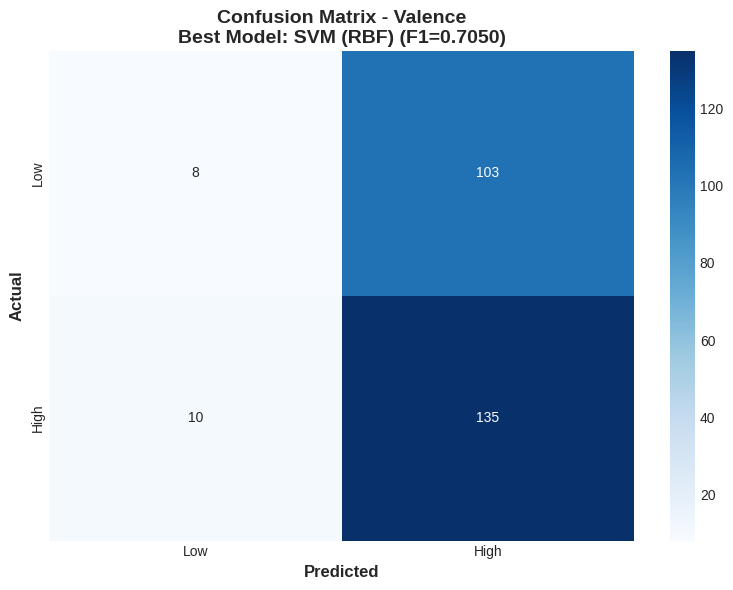


Classification Report - VALENCE (SVM (RBF)):
              precision    recall  f1-score   support

         Low     0.4444    0.0721    0.1240       111
        High     0.5672    0.9310    0.7050       145

    accuracy                         0.5586       256
   macro avg     0.5058    0.5016    0.4145       256
weighted avg     0.5140    0.5586    0.4531       256



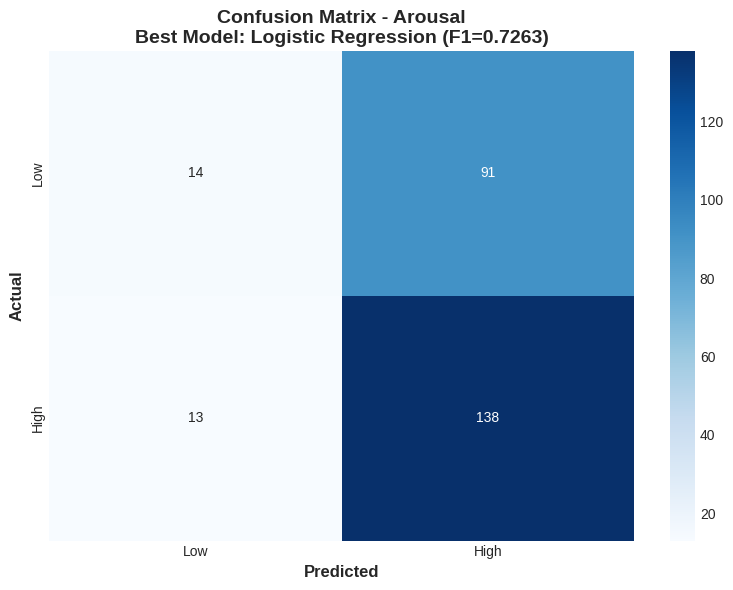


Classification Report - AROUSAL (Logistic Regression):
              precision    recall  f1-score   support

         Low     0.5185    0.1333    0.2121       105
        High     0.6026    0.9139    0.7263       151

    accuracy                         0.5938       256
   macro avg     0.5606    0.5236    0.4692       256
weighted avg     0.5681    0.5938    0.5154       256



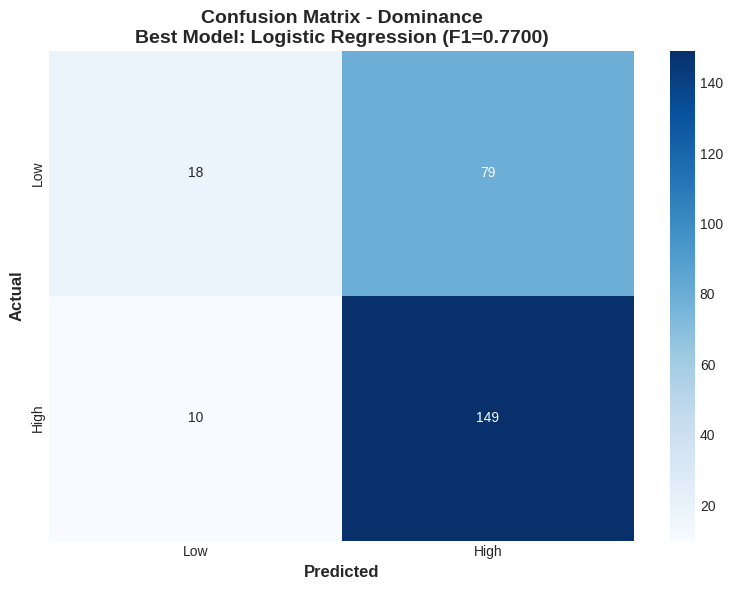


Classification Report - DOMINANCE (Logistic Regression):
              precision    recall  f1-score   support

         Low     0.6429    0.1856    0.2880        97
        High     0.6535    0.9371    0.7700       159

    accuracy                         0.6523       256
   macro avg     0.6482    0.5613    0.5290       256
weighted avg     0.6495    0.6523    0.5874       256



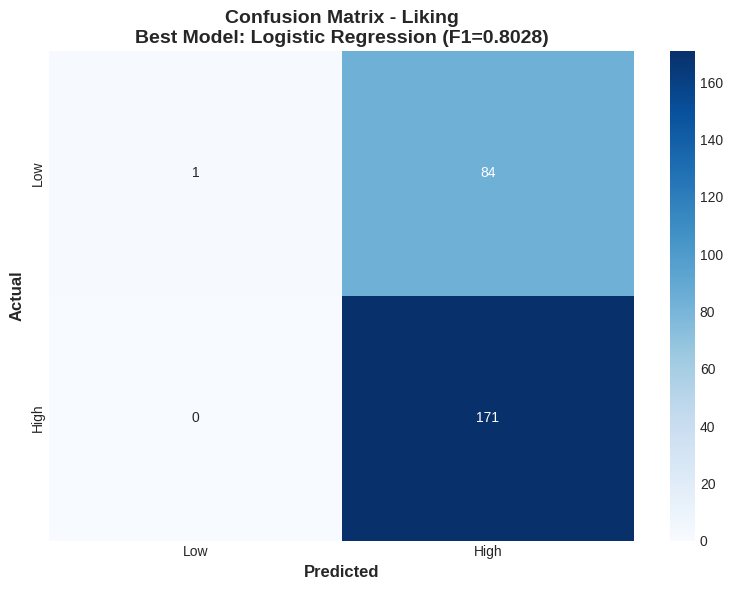


Classification Report - LIKING (Logistic Regression):
              precision    recall  f1-score   support

         Low     1.0000    0.0118    0.0233        85
        High     0.6706    1.0000    0.8028       171

    accuracy                         0.6719       256
   macro avg     0.8353    0.5059    0.4130       256
weighted avg     0.7800    0.6719    0.5440       256



In [14]:
# Plot confusion matrices for best models
for emotion in EMOTION_LABELS:
    results_df = all_results[emotion]['results_df']
    results_list = all_results[emotion]['results_list']
    X_test, y_test = all_results[emotion]['test_data']

    # Find best model (highest F1-score)
    best_idx = results_df['F1-Score'].idxmax()
    best_results = results_list[best_idx]

    # Compute confusion matrix
    cm = confusion_matrix(y_test, best_results['y_pred'])

    # Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
    plt.xlabel('Predicted', fontsize=12, fontweight='bold')
    plt.ylabel('Actual', fontsize=12, fontweight='bold')
    plt.title(f'Confusion Matrix - {emotion.capitalize()}\nBest Model: {best_results["model"]} (F1={best_results["f1"]:.4f})',
              fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'/content/drive/My Drive/DeapDb/Classification/confusion_matrix_{emotion}.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print classification report
    print(f"\nClassification Report - {emotion.upper()} ({best_results['model']}):")
    print("=" * 70)
    print(classification_report(y_test, best_results['y_pred'],
                                target_names=['Low', 'High'], digits=4))

## 14. ROC Curves

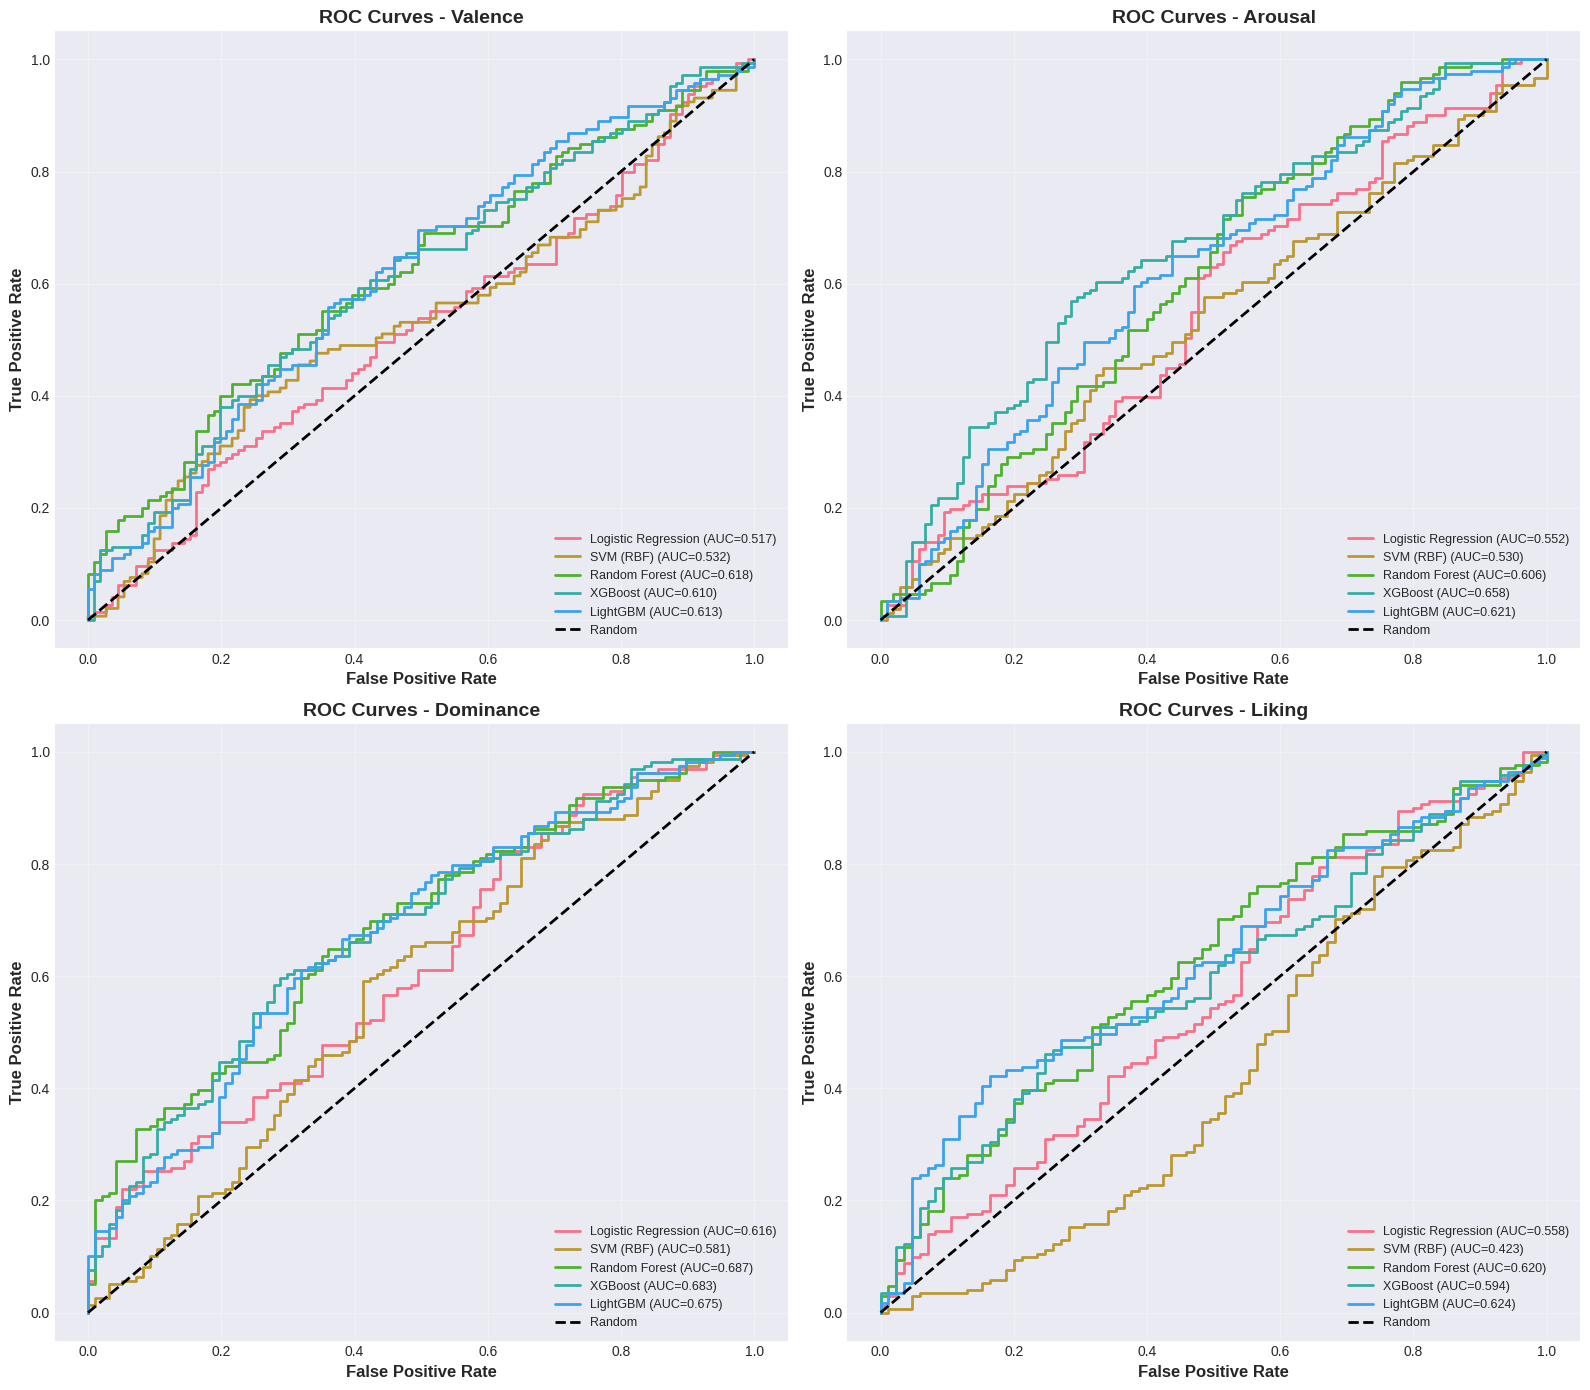

In [15]:
# Plot ROC curves for all models
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.ravel()

for idx, emotion in enumerate(EMOTION_LABELS):
    results_list = all_results[emotion]['results_list']
    X_test, y_test = all_results[emotion]['test_data']

    for results in results_list:
        if results['y_pred_proba'] is not None:
            fpr, tpr, _ = roc_curve(y_test, results['y_pred_proba'])
            auc = roc_auc_score(y_test, results['y_pred_proba'])
            axes[idx].plot(fpr, tpr, label=f"{results['model']} (AUC={auc:.3f})", linewidth=2)

    axes[idx].plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random')
    axes[idx].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
    axes[idx].set_title(f'ROC Curves - {emotion.capitalize()}', fontsize=14, fontweight='bold')
    axes[idx].legend(loc='lower right', fontsize=9)
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('/content/drive/My Drive/DeapDb/Classification/roc_curves_all_emotions.png', dpi=300, bbox_inches='tight')
plt.show()

## 15. Feature Importance Analysis (for tree-based models)


Feature Importance Analysis - VALENCE


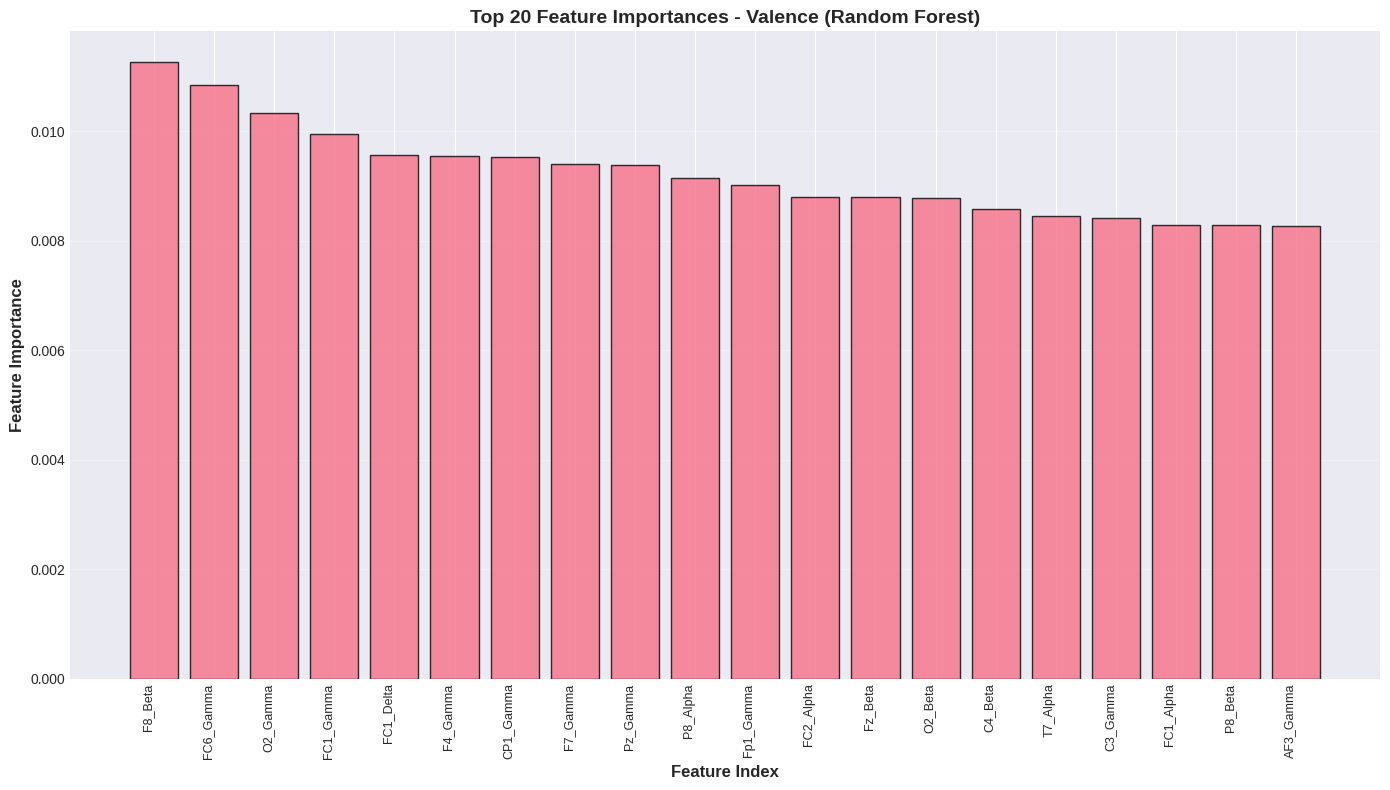


Top 10 most important features:
  1. F8_Beta             : 0.011258
  2. FC6_Gamma           : 0.010836
  3. O2_Gamma            : 0.010324
  4. FC1_Gamma           : 0.009938
  5. FC1_Delta           : 0.009561
  6. F4_Gamma            : 0.009545
  7. CP1_Gamma           : 0.009532
  8. F7_Gamma            : 0.009399
  9. Pz_Gamma            : 0.009388
  10. P8_Alpha            : 0.009134

Feature Importance Analysis - AROUSAL


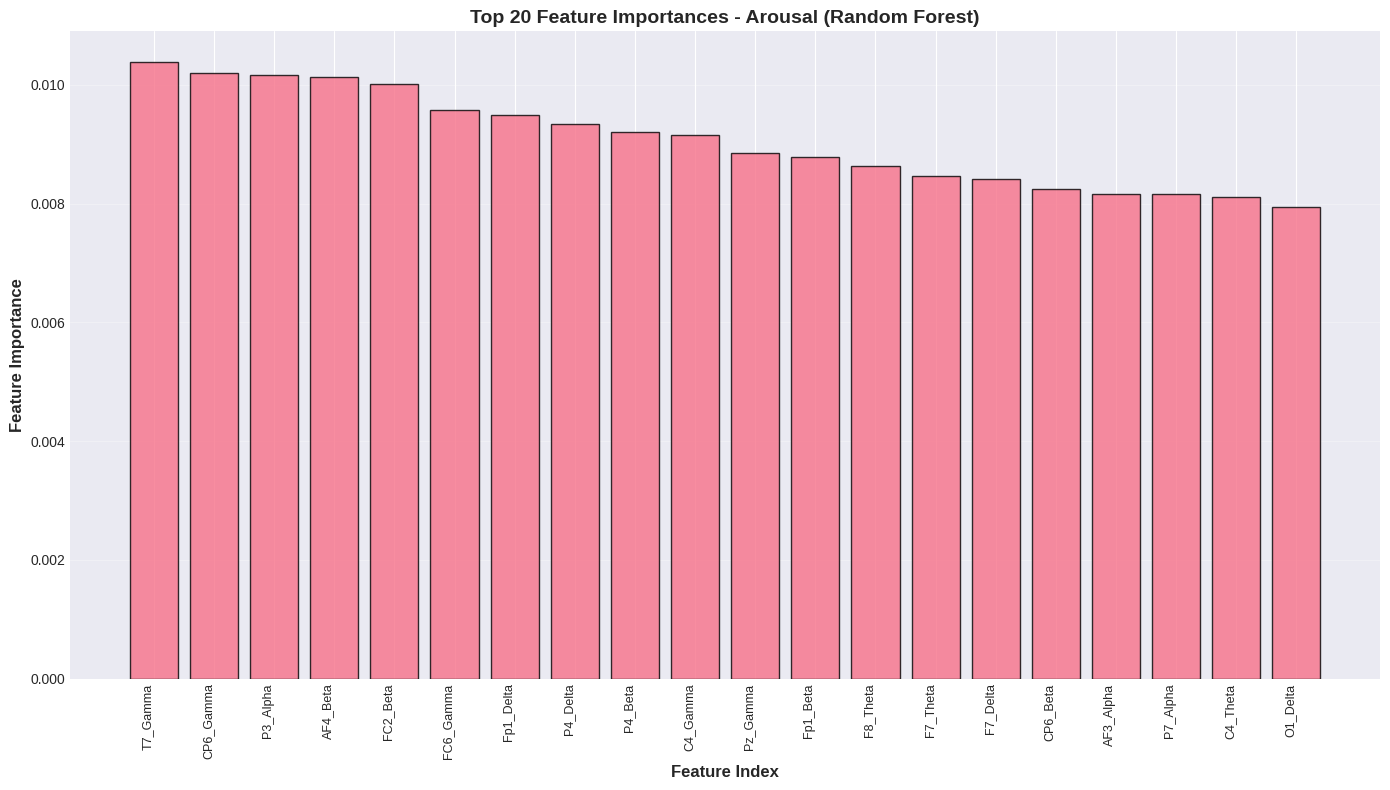


Top 10 most important features:
  1. T7_Gamma            : 0.010385
  2. CP6_Gamma           : 0.010201
  3. P3_Alpha            : 0.010172
  4. AF4_Beta            : 0.010129
  5. FC2_Beta            : 0.010011
  6. FC6_Gamma           : 0.009587
  7. Fp1_Delta           : 0.009486
  8. P4_Delta            : 0.009350
  9. P4_Beta             : 0.009216
  10. C4_Gamma            : 0.009150

Feature Importance Analysis - DOMINANCE


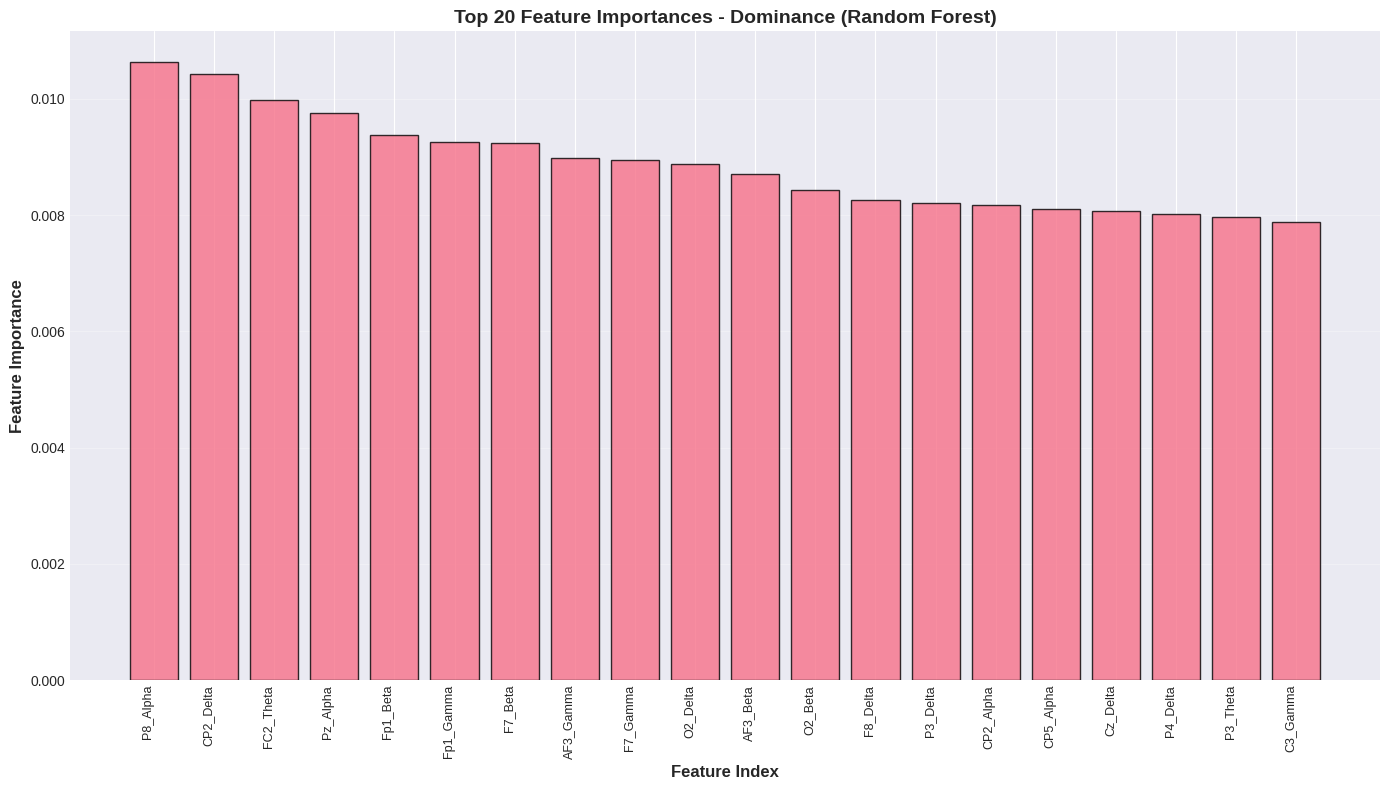


Top 10 most important features:
  1. P8_Alpha            : 0.010632
  2. CP2_Delta           : 0.010434
  3. FC2_Theta           : 0.009989
  4. Pz_Alpha            : 0.009751
  5. Fp1_Beta            : 0.009386
  6. Fp1_Gamma           : 0.009262
  7. F7_Beta             : 0.009243
  8. AF3_Gamma           : 0.008991
  9. F7_Gamma            : 0.008954
  10. O2_Delta            : 0.008874

Feature Importance Analysis - LIKING


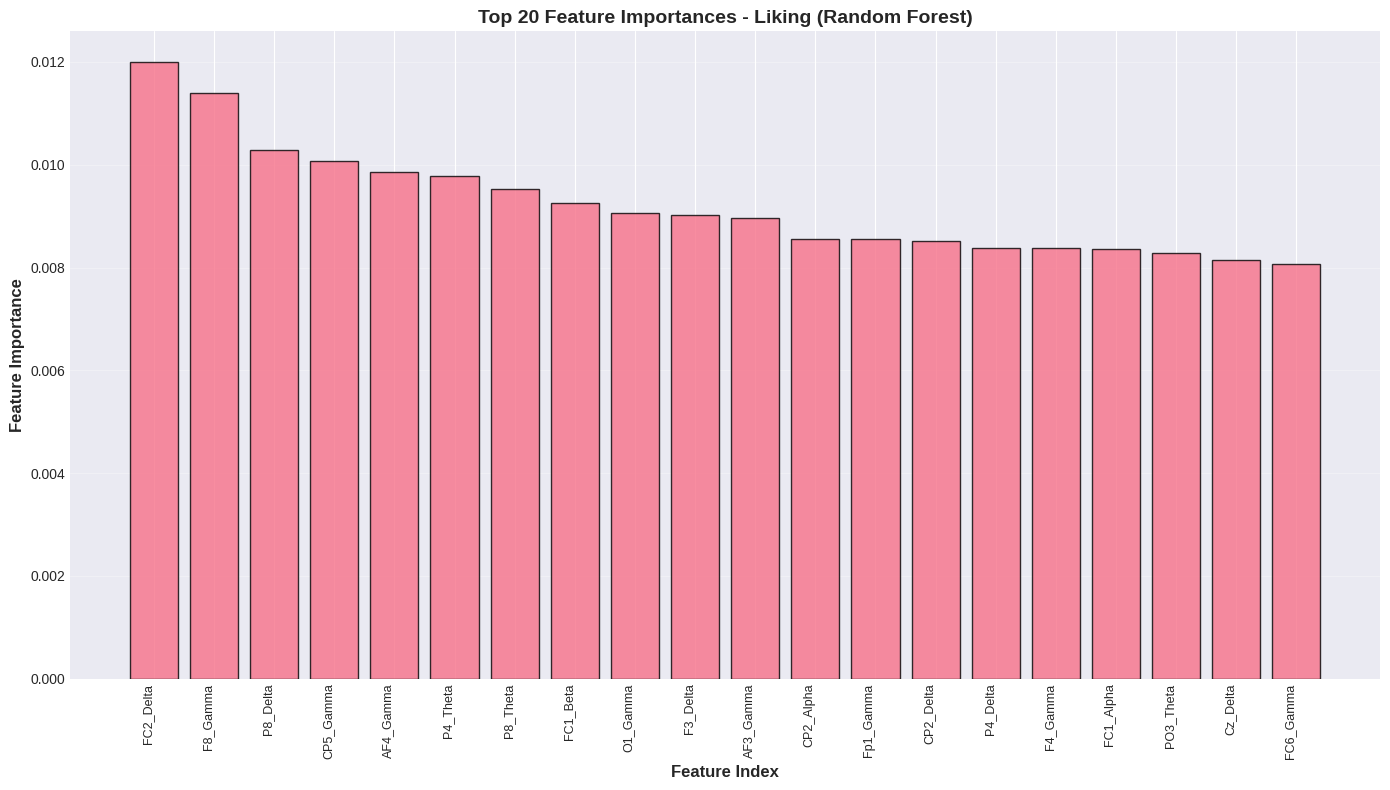


Top 10 most important features:
  1. FC2_Delta           : 0.011997
  2. F8_Gamma            : 0.011387
  3. P8_Delta            : 0.010295
  4. CP5_Gamma           : 0.010080
  5. AF4_Gamma           : 0.009860
  6. P4_Theta            : 0.009787
  7. P8_Theta            : 0.009520
  8. FC1_Beta            : 0.009262
  9. O1_Gamma            : 0.009066
  10. F3_Delta            : 0.009023


In [16]:
# Analyze feature importance for Random Forest
for emotion in EMOTION_LABELS:
    print(f"\n{'='*80}")
    print(f"Feature Importance Analysis - {emotion.upper()}")
    print(f"{'='*80}")

    # Get data
    X_full = X
    y = y_binary[emotion]

    # Split and preprocess
    X_train, X_test, y_train, y_test = train_test_split(
        X_full, y, test_size=0.2, random_state=42, stratify=y
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Train Random Forest (no PCA - use features directly to see feature names)
    rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
    rf_model.fit(X_train_scaled, y_train)

    # Get feature importances
    importances = rf_model.feature_importances_
    indices = np.argsort(importances)[::-1][:20]  # Top 20 features

    # Plot
    plt.figure(figsize=(14, 8))
    plt.bar(range(20), importances[indices], align='center', alpha=0.8, edgecolor='black')
    plt.xlabel('Feature Index', fontsize=12, fontweight='bold')
    plt.ylabel('Feature Importance', fontsize=12, fontweight='bold')
    plt.title(f'Top 20 Feature Importances - {emotion.capitalize()} (Random Forest)',
              fontsize=14, fontweight='bold')
    plt.xticks(range(20), [feature_names[i] for i in indices], rotation=90, ha='right', fontsize=9)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'/content/drive/My Drive/DeapDb/Classification/feature_importance_{emotion}.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\nTop 10 most important features:")
    for i, idx in enumerate(indices[:10]):
        print(f"  {i+1}. {feature_names[idx]:<20s}: {importances[idx]:.6f}")

## 16. Cross-Validation Analysis


CROSS-VALIDATION ANALYSIS (5-Fold)

VALENCE:
--------------------------------------------------------------------------------
Best Model: SVM (RBF)
CV Scores: [0.71979434 0.70557029 0.68965517 0.70712401 0.70649351]
Mean F1-Score: 0.7057 (+/- 0.0096)

AROUSAL:
--------------------------------------------------------------------------------
Best Model: Logistic Regression
CV Scores: [0.72340426 0.72395833 0.74300254 0.7357513  0.72020725]
Mean F1-Score: 0.7293 (+/- 0.0087)

DOMINANCE:
--------------------------------------------------------------------------------
Best Model: Logistic Regression
CV Scores: [0.75452196 0.7638191  0.75949367 0.77419355 0.76530612]
Mean F1-Score: 0.7635 (+/- 0.0065)

LIKING:
--------------------------------------------------------------------------------
Best Model: Logistic Regression
CV Scores: [0.78859857 0.80470588 0.79807692 0.78554217 0.80094787]
Mean F1-Score: 0.7956 (+/- 0.0073)


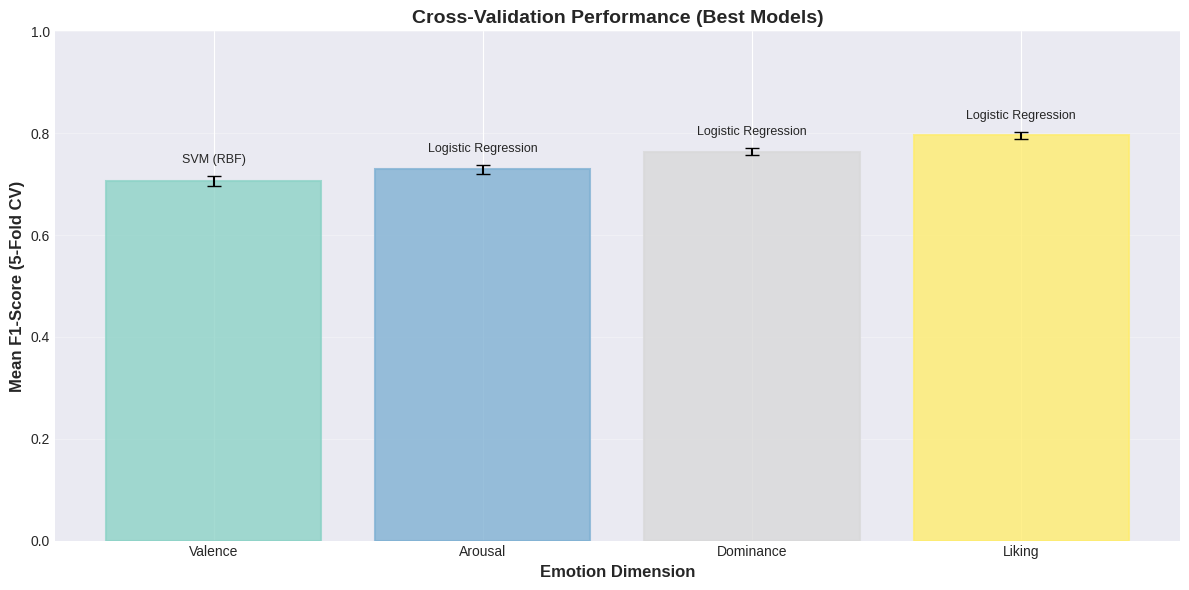

In [17]:
# Perform k-fold cross-validation for best models
print("\n" + "="*80)
print("CROSS-VALIDATION ANALYSIS (5-Fold)")
print("="*80)

cv_results = {}

for emotion in EMOTION_LABELS:
    print(f"\n{emotion.upper()}:")
    print("-" * 80)

    # Get best model from previous results
    results_df = all_results[emotion]['results_df']
    best_model_name = results_df.loc[results_df['F1-Score'].idxmax(), 'Model']

    # Prepare data
    X_full = X
    y = y_binary[emotion]

    # Preprocess
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_full)

    pca = PCA(n_components=0.95, random_state=42)
    X_pca = pca.fit_transform(X_scaled)

    # Define model
    if 'Logistic' in best_model_name:
        model = LogisticRegression(max_iter=1000, random_state=42)
    elif 'SVM' in best_model_name:
        model = SVC(kernel='rbf', probability=True, random_state=42)
    elif 'Random Forest' in best_model_name:
        model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
    elif 'XGBoost' in best_model_name:
        model = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1,
                             random_state=42, eval_metric='logloss')
    elif 'LightGBM' in best_model_name:
        model = LGBMClassifier(n_estimators=100, max_depth=6, learning_rate=0.1,
                              random_state=42, verbose=-1)
    elif 'MLP' in best_model_name:
        model = MLPClassifier(hidden_layers=(128, 64), max_iter=500, random_state=42)
    else:  # KNN
        model = KNeighborsClassifier(n_neighbors=5)

    # Perform cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_pca, y, cv=cv, scoring='f1')

    cv_results[emotion] = {
        'model': best_model_name,
        'scores': cv_scores,
        'mean': cv_scores.mean(),
        'std': cv_scores.std()
    }

    print(f"Best Model: {best_model_name}")
    print(f"CV Scores: {cv_scores}")
    print(f"Mean F1-Score: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

# Visualize CV results
fig, ax = plt.subplots(figsize=(12, 6))

emotions_list = list(cv_results.keys())
means = [cv_results[e]['mean'] for e in emotions_list]
stds = [cv_results[e]['std'] for e in emotions_list]
models = [cv_results[e]['model'] for e in emotions_list]

x_pos = np.arange(len(emotions_list))
bars = ax.bar(x_pos, means, yerr=stds, capsize=5, alpha=0.8, edgecolor='black', linewidth=1.5)

# Color bars
colors = plt.cm.Set3(np.linspace(0, 1, len(emotions_list)))
for bar, color in zip(bars, colors):
    bar.set_color(color)

ax.set_xlabel('Emotion Dimension', fontsize=12, fontweight='bold')
ax.set_ylabel('Mean F1-Score (5-Fold CV)', fontsize=12, fontweight='bold')
ax.set_title('Cross-Validation Performance (Best Models)', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels([e.capitalize() for e in emotions_list])
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

# Add model names on bars
for i, (bar, model) in enumerate(zip(bars, models)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + stds[i] + 0.02,
            model, ha='center', va='bottom', fontsize=9, rotation=0)

plt.tight_layout()
plt.savefig('/content/drive/My Drive/DeapDb/Classification/cross_validation_results.png', dpi=300, bbox_inches='tight')
plt.show()

## 17. Final Summary and Key Insights

In [18]:
print("\n" + "="*100)
print("FINAL SUMMARY - DEAP EMOTION RECOGNITION PROJECT")
print("="*100)

print("\n1. DATASET OVERVIEW:")
print(f"   - Total samples: {X.shape[0]} (32 subjects × 40 trials)")
print(f"   - Total features extracted: {X.shape[1]}")
print(f"   - Feature types: Statistical, Frequency-domain, Connectivity")
print(f"   - Emotion dimensions: {', '.join(EMOTION_LABELS)}")

print("\n2. BEST PERFORMING MODELS (by F1-Score):")
for emotion in EMOTION_LABELS:
    results_df = all_results[emotion]['results_df']
    best_idx = results_df['F1-Score'].idxmax()
    best_model = results_df.loc[best_idx, 'Model']
    best_f1 = results_df.loc[best_idx, 'F1-Score']
    best_acc = results_df.loc[best_idx, 'Accuracy']

    print(f"   {emotion.capitalize()}:")
    print(f"      Model: {best_model}")
    print(f"      Accuracy: {best_acc:.4f}")
    print(f"      F1-Score: {best_f1:.4f}")
    print(f"      CV Mean F1: {cv_results[emotion]['mean']:.4f} (+/- {cv_results[emotion]['std']:.4f})")

print("\n3. KEY FINDINGS:")
avg_accuracy = np.mean([all_results[e]['results_df']['Accuracy'].max() for e in EMOTION_LABELS])
avg_f1 = np.mean([all_results[e]['results_df']['F1-Score'].max() for e in EMOTION_LABELS])

print(f"   - Average best accuracy across emotions: {avg_accuracy:.4f}")
print(f"   - Average best F1-score across emotions: {avg_f1:.4f}")
print(f"   - Most challenging emotion: {min(EMOTION_LABELS, key=lambda e: all_results[e]['results_df']['F1-Score'].max()).capitalize()}")
print(f"   - Easiest emotion to classify: {max(EMOTION_LABELS, key=lambda e: all_results[e]['results_df']['F1-Score'].max()).capitalize()}")

print("\n4. FILES SAVED:")
print("   - Model performance CSVs for each emotion")
print("   - Confusion matrices")
print("   - ROC curves")
print("   - Feature importance plots")
print("   - Cross-validation results")
print("   - Data distribution plots")


FINAL SUMMARY - DEAP EMOTION RECOGNITION PROJECT

1. DATASET OVERVIEW:
   - Total samples: 1280 (32 subjects × 40 trials)
   - Total features extracted: 160
   - Feature types: Statistical, Frequency-domain, Connectivity
   - Emotion dimensions: valence, arousal, dominance, liking

2. BEST PERFORMING MODELS (by F1-Score):
   Valence:
      Model: SVM (RBF)
      Accuracy: 0.5586
      F1-Score: 0.7050
      CV Mean F1: 0.7057 (+/- 0.0096)
   Arousal:
      Model: Logistic Regression
      Accuracy: 0.5938
      F1-Score: 0.7263
      CV Mean F1: 0.7293 (+/- 0.0087)
   Dominance:
      Model: Logistic Regression
      Accuracy: 0.6523
      F1-Score: 0.7700
      CV Mean F1: 0.7635 (+/- 0.0065)
   Liking:
      Model: Logistic Regression
      Accuracy: 0.6719
      F1-Score: 0.8028
      CV Mean F1: 0.7956 (+/- 0.0073)

3. KEY FINDINGS:
   - Average best accuracy across emotions: 0.6357
   - Average best F1-score across emotions: 0.7510
   - Most challenging emotion: Valence
   - Easi

## 18. Export Best Models

In [19]:
import joblib

# Save best models and preprocessors
print("Saving best models...")

for emotion in EMOTION_LABELS:
    # Get best model
    results_df = all_results[emotion]['results_df']
    best_idx = results_df['F1-Score'].idxmax()
    best_model_name = results_df.loc[best_idx, 'Model']

    # Prepare data and train final model
    X_full = X
    y = y_binary[emotion]

    # Preprocess
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_full)

    pca = PCA(n_components=0.95, random_state=42)
    X_pca = pca.fit_transform(X_scaled)

    # Train best model on full dataset
    if 'Logistic' in best_model_name:
        model = LogisticRegression(max_iter=1000, random_state=42)
    elif 'SVM' in best_model_name:
        model = SVC(kernel='rbf', probability=True, random_state=42)
    elif 'Random Forest' in best_model_name:
        model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
    elif 'XGBoost' in best_model_name:
        model = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1,
                             random_state=42, eval_metric='logloss')
    else:
        model = LGBMClassifier(n_estimators=100, max_depth=6, learning_rate=0.1,
                              random_state=42, verbose=-1)

    # Save model and preprocessors
    model_package = {
        'model': model,
        'scaler': scaler,
        'pca': pca,
        'model_name': best_model_name,
        'emotion': emotion
    }

    joblib.dump(model_package, f'/content/drive/My Drive/DeapDb/Classification/best_model_{emotion}.pkl')
    print(f"✓ {emotion.capitalize()} model saved ({best_model_name})")

print("\n✓ All best models saved successfully!")

Saving best models...
✓ Valence model saved (SVM (RBF))
✓ Arousal model saved (Logistic Regression)
✓ Dominance model saved (Logistic Regression)
✓ Liking model saved (Logistic Regression)

✓ All best models saved successfully!


<div dir="rtl">

# خلاصه نتایج

بر اساس تحلیل انجام شده:

* **Liking (مورد علاقه بودن)** با بالاترین F1-Score (حدود 0.80) و **Valence (ارزش)** با پایین‌ترین F1-Score (حدود 0.70) به ترتیب آسان‌ترین و چالش‌برانگیزترین بعد احساسی برای طبقه‌بندی بودند.
* مدل **رگرسیون لجستیک** در ابعاد Arousal، Dominance و Liking بهترین عملکرد (بالاترین F1-Score) را داشت، در حالی که مدل **SVM (RBF)** برای بعد Valence بهترین بود.
* میانگین بهترین F1-Score در بین ابعاد احساسی حدود 0.75 بود که نشان‌دهنده توانایی مدل‌ها در طبقه‌بندی این احساسات بر اساس ویژگی‌های EEG است.
* تجزیه و تحلیل اهمیت ویژگی‌ها نشان داد که باندهای فرکانسی و کانال‌های مختلف EEG برای تشخیص هر بعد احساسی متفاوت هستند.
* نتایج اعتبارسنجی متقابل (Cross-Validation) نیز پایداری نسبی عملکرد بهترین مدل‌ها را در برابر داده‌های دیده نشده تأیید کرد.

</div>